In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
39901,NaN,NaN,International,2020-08-25,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39902,NaN,NaN,International,2020-08-26,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39903,NaN,NaN,International,2020-08-27,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


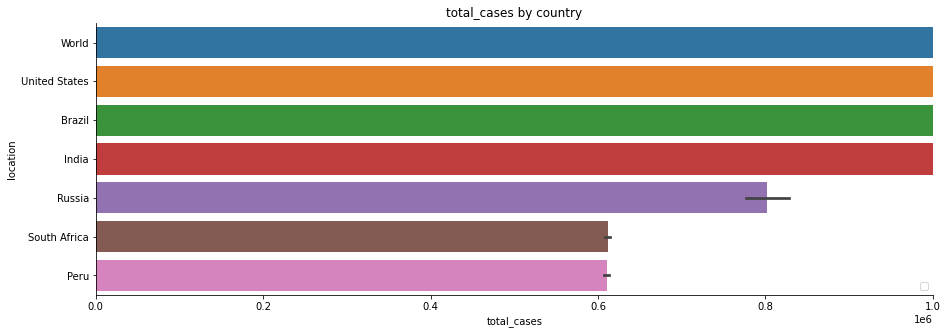

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


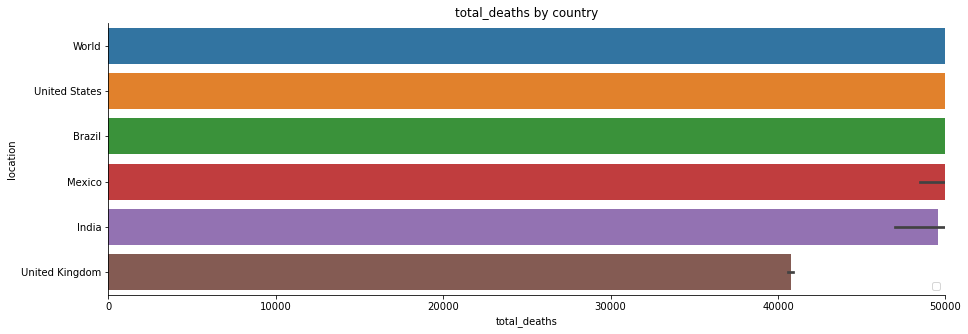

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


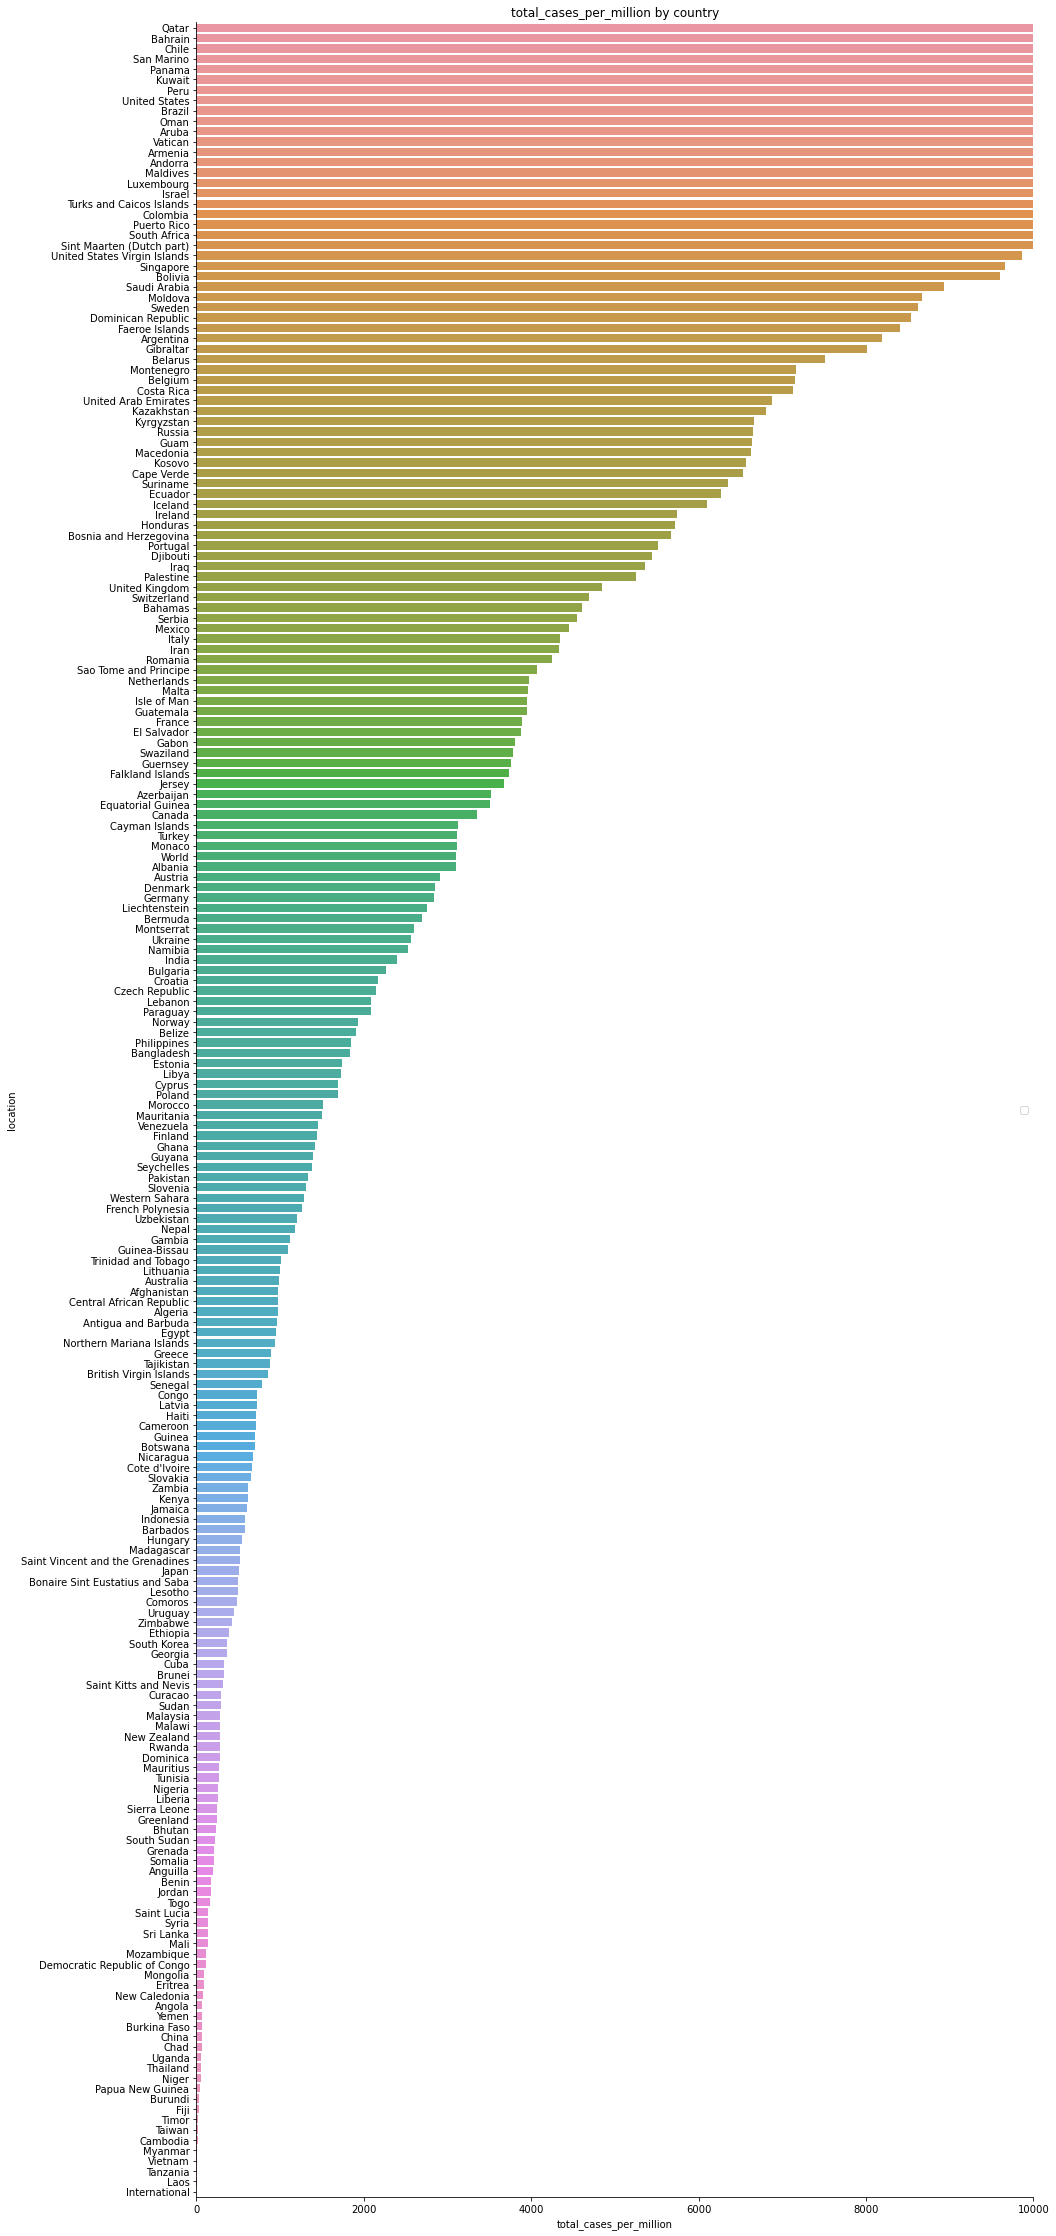

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


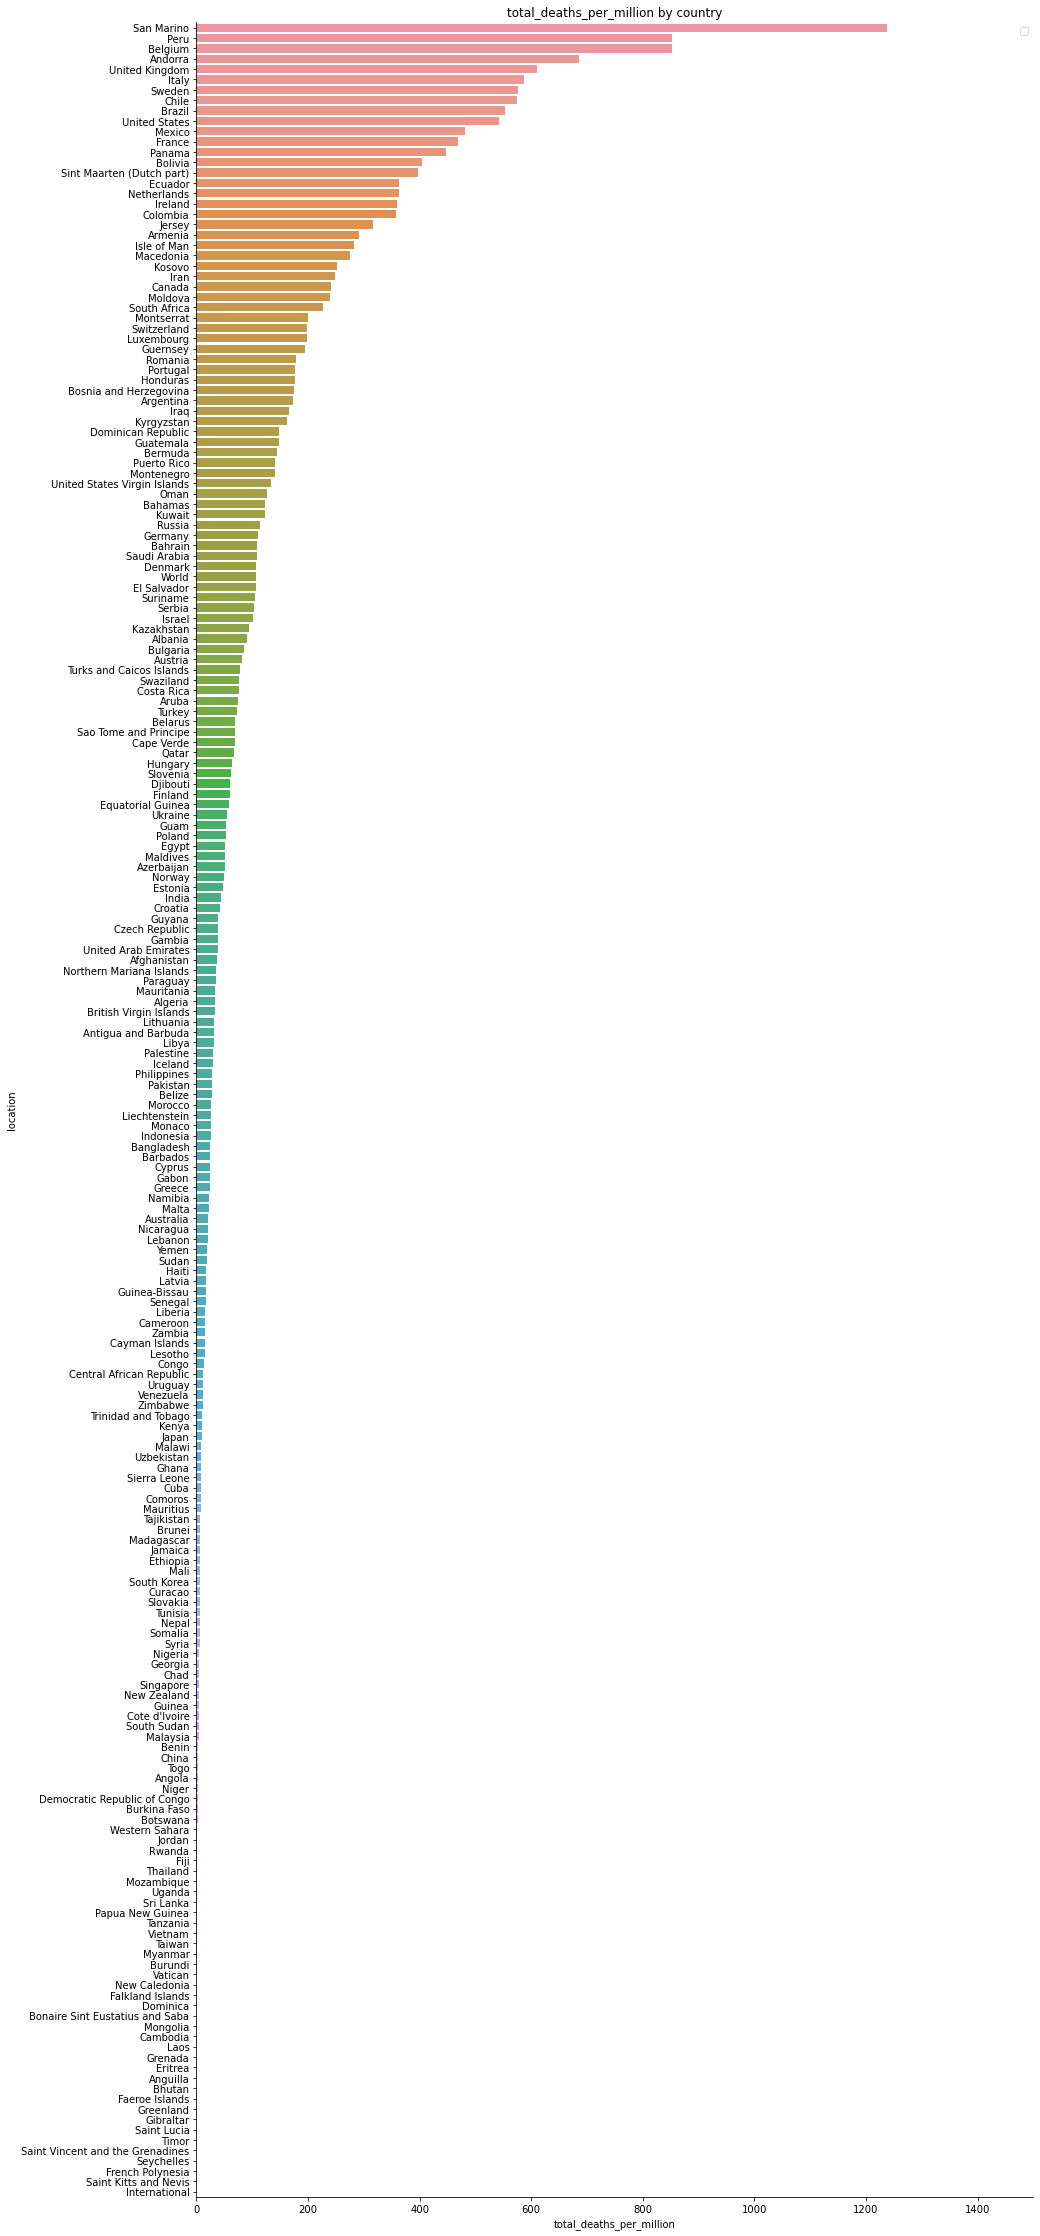

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

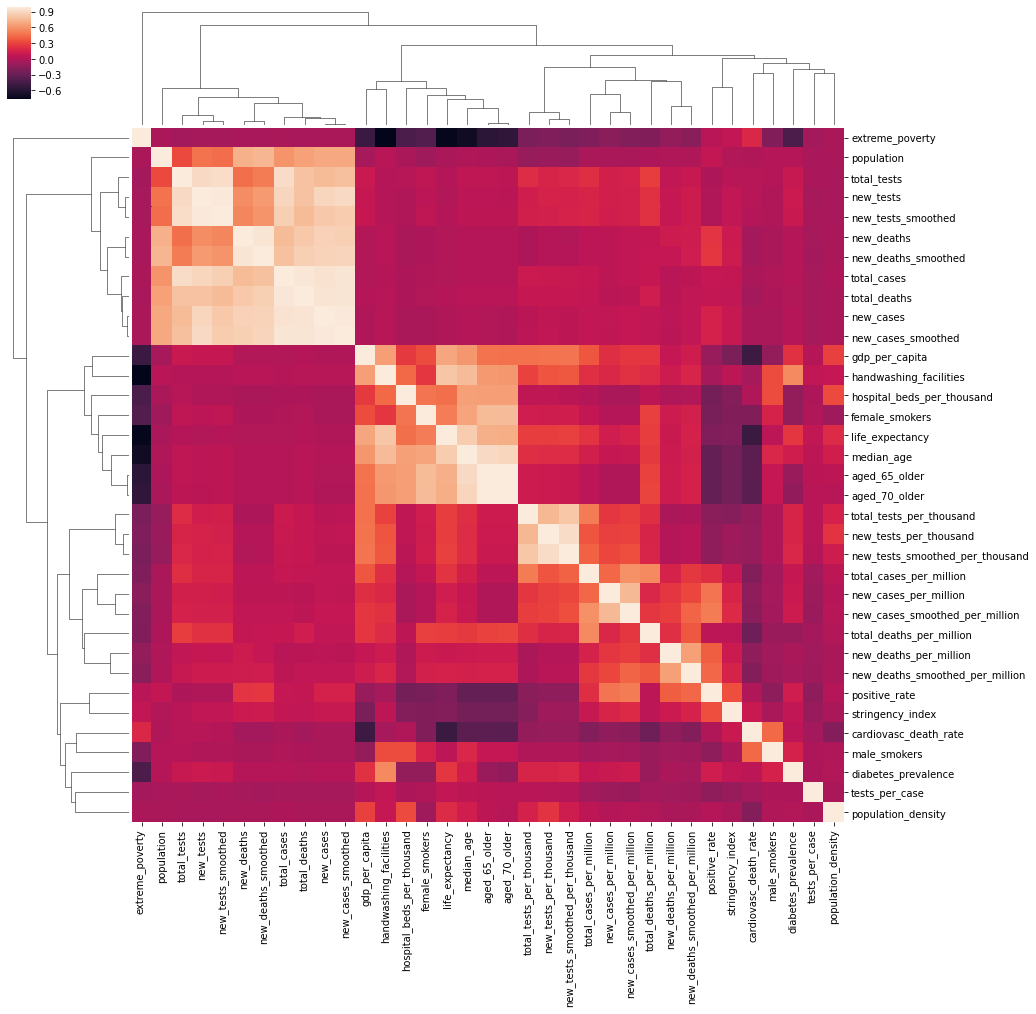

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9994422718619437 (+/- 0.0004092085918802602)
Coef :  [1.03868710e+00 9.37467182e-05 9.82938549e-05]
3 Last_days :  [[23681725 23936430 24204686]]
Today :  24204686
Prediction + :  476137
Tomorow :  24680823
                                     
--------- Total Death -----------------
                                     
R^2: 0.999593317125233 (+/- 0.00010499212080904483)
Coef :  [0.00426601 0.48621899 0.51963843]
3 Last_days :  [[813427 819801 826090]]
Today :  826090
Prediction + :  7683
Tomorow :  833773
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9943494579019627 (+/- 0.0018110669847057098)
Coef :  [-0.67837236  0.73732814  0.94279697]
3 Last_days :  [[244854 248158 253587]]
Today :  253587
Prediction + :  2623
Tomorow :  256210
                                     
--------- Total Death -----------------
                                     
R^2: 0.35225606566198575 (+/- 0.904593991052006)
Coef :  [-0.75333706  0.78865291  0.96374371]
3 Last_days :  [[30528 30544 30544]]
Today :  30544
Prediction + :  35
Tomorow :  30579
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8975682101139012 (+/- 0.07490906808550836)
Coef :  [-0.32387042 -0.02124636  1.33938685]
3 Last_days :  [[89718 89752 89784]]
Today :  89784
Prediction + :  35
Tomorow :  89819
                                     
--------- Total Death -----------------
                                     
R^2: -293.34341601927684 (+/- 416.09258063046155)
Coef :  [-0.07690585  0.01243233  1.05641829]
3 Last_days :  [[4711 4712 4713]]
Today :  4713
Prediction + :  6
Tomorow :  4719
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5491632248125514 (+/- 0.6363438244302451)
Coef :  [-0.83093931  0.90174537  0.9284471 ]
3 Last_days :  [[260298 261174 262540]]
Today :  262540
Prediction + :  813
Tomorow :  263353
                                     
--------- Total Death -----------------
                                     
R^2: 0.822706137750601 (+/- 0.2240822420326656)
Coef :  [-0.8308915   0.90071004  0.92932695]
3 Last_days :  [[35441 35445 35458]]
Today :  35458
Prediction + :  24
Tomorow :  35482
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6703901960490425 (+/- 0.4552383224747033)
Coef :  [-0.58441689  0.42749549  1.15825264]
3 Last_days :  [[405436 412553 419849]]
Today :  419849
Prediction + :  6152
Tomorow :  426001
                                     
--------- Total Death -----------------
                                     
R^2: 0.18259550394468904 (+/- 0.9742510619082186)
Coef :  [-0.72227623  0.61951415  1.10177215]
3 Last_days :  [[28872 28924 28971]]
Today :  28971
Prediction + :  51
Tomorow :  29022
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9896949247684637 (+/- 0.014321335317920611)
Coef :  [0.06396797 0.47084415 0.48197685]
3 Last_days :  [[5740909 5779028 5821876]]
Today :  5821876
Prediction + :  85085
Tomorow :  5906961
                                     
--------- Total Death -----------------
                                     
R^2: 0.4463045360117322 (+/- 0.7811725006003868)
Coef :  [-0.56916629  0.74310218  0.82858651]
3 Last_days :  [[177279 178486 179714]]
Today :  179714
Prediction + :  1222
Tomorow :  180936
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9569228984104038 (+/- 0.059465088344667336)
Coef :  [-0.75470755  0.86444715  0.89036835]
3 Last_days :  [[326614 327798 328846]]
Today :  328846
Prediction + :  1295
Tomorow :  330141
                                     
--------- Total Death -----------------
                                     
R^2: 0.3961387621860985 (+/- 0.8238014450538074)
Coef :  [-0.77386372  0.83227675  0.94103199]
3 Last_days :  [[41433 41449 41465]]
Today :  41465
Prediction + :  49
Tomorow :  41514
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9988010483629141 (+/- 0.00039305092863902916)
Coef :  [-0.80261491  0.85984042  0.94245994]
3 Last_days :  [[234853 236429 237936]]
Today :  237936
Prediction + :  1404
Tomorow :  239340
                                     
--------- Total Death -----------------
                                     
R^2: 0.40029404692502357 (+/- 0.8365916623271662)
Coef :  [-0.79352489  0.84168464  0.95119065]
3 Last_days :  [[9277 9280 9285]]
Today :  9285
Prediction + :  9
Tomorow :  9294
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -1.2492489900474582 (+/- 3.179860809723525)
Coef :  [0.19014786 0.41255002 0.40905088]
3 Last_days :  [[358905 361150 363363]]
Today :  363363
Prediction + :  3808
Tomorow :  367171
                                     
--------- Total Death -----------------
                                     
R^2: 0.9148930994557386 (+/- 0.11967282856979271)
Coef :  [-0.02292192  0.52236314  0.51293727]
3 Last_days :  [[20643 20776 20901]]
Today :  20901
Prediction + :  247
Tomorow :  21148
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9986314418415093 (+/- 0.00166863584529411)
Coef :  [-0.74507219  0.8518221   0.89052928]
3 Last_days :  [[259692 261194 262507]]
Today :  262507
Prediction + :  1269
Tomorow :  263776
                                     
--------- Total Death -----------------
                                     
R^2: 0.9992815829608014 (+/- 0.0007101546274041479)
Coef :  [-0.81396823  0.89610588  0.91484865]
3 Last_days :  [[6139 6163 6183]]
Today :  6183
Prediction + :  21
Tomorow :  6204
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.45484381563130755 (+/- 0.7662459221513852)
Coef :  [-0.18302121  0.51015505  0.68911609]
3 Last_days :  [[3622861 3669995 3717156]]
Today :  3717156
Prediction + :  59201
Tomorow :  3776357
                                     
--------- Total Death -----------------
                                     
R^2: 0.49318655449520593 (+/- 0.70905088508485)
Coef :  [-0.14610125  0.53333186  0.62559383]
3 Last_days :  [[115309 116580 117665]]
Today :  117665
Prediction + :  1514
Tomorow :  119179
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(24204686, 826090, 24680823, 833773),
 (253587, 30544, 256210, 30579),
 (262540, 35458, 263353, 35482),
 (419849, 28971, 426001, 29022),
 (5821876, 179714, 5906961, 180936),
 (89784, 4713, 89819, 4719),
 (328846, 41465, 330141, 41514),
 (237936, 9285, 239340, 9294),
 (363363, 20901, 367171, 21148),
 (262507, 6183, 263776, 6204),
 (3717156, 117665, 3776357, 119179)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-27,France,256210.0,0.0,30579.0,0.0,0.0,0.0
0,2020-08-27,China,89819.0,0.0,4719.0,0.0,0.0,0.0
0,2020-08-27,Italy,263353.0,0.0,35482.0,0.0,0.0,0.0
0,2020-08-27,Spain,426001.0,0.0,29022.0,0.0,0.0,0.0
0,2020-08-27,United States,5906961.0,0.0,180936.0,0.0,0.0,0.0
0,2020-08-27,World,24680823.0,0.0,833773.0,0.0,0.0,0.0
0,2020-08-27,United Kingdom,330141.0,0.0,41514.0,0.0,0.0,0.0
0,2020-08-27,Germany,239340.0,0.0,9294.0,0.0,0.0,0.0
0,2020-08-27,Iran,367171.0,0.0,21148.0,0.0,0.0,0.0
0,2020-08-27,Turkey,263776.0,0.0,6204.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")